In [4]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from dataloaders.nascar import NascarDataLoader
from dataloaders.bouncing_data import BouncingBallDataLoader
from torch.utils.data import DataLoader
from models.KalmanVAE import KalmanVAE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dl = BouncingBallDataLoader('/data2/users/cb221/bouncing_ball_data_squares_4_vel/train')
train_loader = DataLoader(dl, batch_size=4, shuffle=True, num_workers=4)
obs_dim = next(iter(train_loader))[1].size(-1)
im, y = next(iter(train_loader))
print(im.size())

In [7]:
kvae = KalmanVAE(1,128,2,4,3,1).float()
print(kvae)
vrslds = KalmanVAE(1,128,2,4,3,1).float()
checkpoint = torch.load('/data2/users/cb221/stored_models/KVAE_black_white_beta_1_alpha_mlp_2_latest.pth.tar', map_location=torch.device('cpu'))
kvae.load_state_dict(checkpoint['kvae'])
kvae.enable_all_grad()

KalmanVAE(
  (encoder): CNNFastEncoder(
    (in_conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (hidden_conv): ModuleList(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (out_mean): Linear(in_features=512, out_features=2, bias=True)
    (out_log_var): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): CNNFastDecoder(
    (in_dec): Linear(in_features=2, out_features=512, bias=True)
    (hidden_convs): ModuleList(
      (0): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (out_conv): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (parameter_net): MLP(
    (fc1): Linear(in_features=2, out_features=16, bias=True)
    (fc2): L

In [33]:
x_hat, a_mu, _, losses = kvae(im[0][:,:25].float())

ValueError: not enough values to unpack (expected 5, got 4)

(1000, 1000)
torch.Size([1000, 1000, 2])


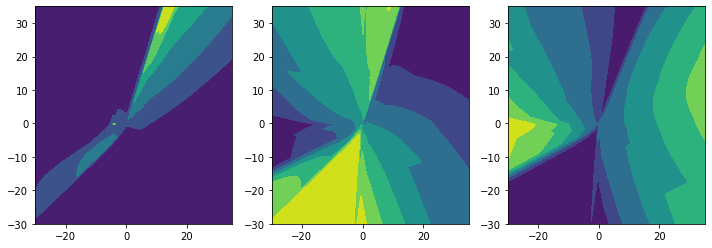

In [31]:
N = 1000
xlist = np.linspace(-30.0, 35.0, N)
ylist = np.linspace(-30.0, 35.0, N)
X, Y = np.meshgrid(xlist, ylist)
print(X.shape)
X_t = torch.from_numpy(X).unsqueeze(-1)
Y_t = torch.from_numpy(Y).unsqueeze(-1)
dom = torch.cat([X_t,Y_t], dim=-1).float()
print(dom.size())
Z = kvae.parameter_net(dom.reshape(-1, 2)).softmax(-1).reshape(N,N,-1).detach().numpy()
fig = plt.figure(figsize=(12,4))
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    cp = ax.contourf(X, Y, Z[:,:,i])
plt.show()

(2000, 2000)
torch.Size([2000, 2000, 2])


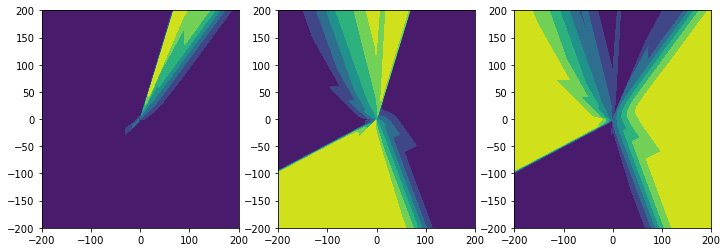

In [28]:
N = 2000
xlist = np.linspace(-200.0, 200.0, N)
ylist = np.linspace(-200.0, 200.0, N)
X, Y = np.meshgrid(xlist, ylist)
print(X.shape)
X_t = torch.from_numpy(X).unsqueeze(-1)
Y_t = torch.from_numpy(Y).unsqueeze(-1)
dom = torch.cat([X_t,Y_t], dim=-1).float()
print(dom.size())
Z = kvae.parameter_net(dom.reshape(-1, 2)).softmax(-1).reshape(N,N,-1).detach().numpy()
fig = plt.figure(figsize=(12,4))
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    cp = ax.contourf(X, Y, Z[:,:,i])
plt.show()